### Code

In [2]:
import os
import json
import copy
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import warnings
warnings.filterwarnings('ignore')


In [3]:
def report_accuracy(result_root, experiments):
    # Iterate over experiments
    for exp in experiments:
        print(f"Experiment: {exp}")
        accs = []
        classwise_accs = []
        all_classes = set()

        fig, axes = plt.subplots(1, 5, figsize=(20, 4))  # Create a row of 5 subplots for confusion matrices

        for split in range(5):
            # Load evaluation file
            eval_path = os.path.join(result_root, exp, f"split{split}", 'evaluation.pt')
            ev = torch.load(eval_path)

            # Extract necessary data
            id_list = ev['id']
            folder_list = ev['folder']
            true_label = np.array(ev['true_label']['age'])
            predicted_label = np.array(ev['predicted_label']['age'])

            # Filter test indices where folder == 2
            test_indices = [i for i in range(len(id_list)) if folder_list[i] == 2]

            if not test_indices:  # Skip if no test samples for this split
                print(f"split{split} has no test samples.")
                continue

            y_true = true_label[test_indices]
            y_pred = predicted_label[test_indices]

            # Compute accuracy
            test_accuracy = accuracy_score(y_true, y_pred)
            accs.append(test_accuracy)

            # Compute classwise accuracy
            report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
            class_accuracies = {int(cls): report[cls]['recall'] for cls in report if cls.isdigit()}  # Extract recall (per-class accuracy)
            classwise_accs.append(class_accuracies)
            all_classes.update(class_accuracies.keys())  # Collect all unique class labels

            # Ensure sorted order of classwise accuracies
            sorted_classes = sorted(all_classes)
            classwise_acc_list = [class_accuracies.get(cls, 0.0) for cls in sorted_classes]

            # Print accuracy for this split
            classwise_str = ", ".join(f"{acc:.4f}" for acc in classwise_acc_list)
            print(f"split{split} accuracy/class-wise-accuracy\t=\t{test_accuracy:.4f} / {classwise_str}")

            # Plot confusion matrix
            cm = confusion_matrix(y_true, y_pred, labels=sorted_classes)
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=sorted_classes, yticklabels=sorted_classes, ax=axes[split])
            axes[split].set_title(f"Split {split}")
            axes[split].set_xlabel("Predicted")
            axes[split].set_ylabel("True")

        # Compute mean and std accuracy over splits
        mean_acc = np.mean(accs)
        std_acc = np.std(accs)
        print(f"\naccuracy over splits: {mean_acc:.4f}  ± {std_acc:.4f}\n")

        # Compute mean and std of classwise accuracy
        classwise_mean_acc = {cls: np.mean([accs[cls] for accs in classwise_accs if cls in accs]) for cls in all_classes}
        classwise_std_acc = {cls: np.std([accs[cls] for accs in classwise_accs if cls in accs]) for cls in all_classes}

        # Sort classwise accuracy by class index
        sorted_classes = sorted(classwise_mean_acc.keys())

        print("Classwise Mean Accuracy (Sorted):")
        for cls in sorted_classes:
            print(f"Class {cls}: {classwise_mean_acc[cls]:.4f} ± {classwise_std_acc[cls]:.4f}")

        plt.tight_layout()
        plt.show()  # Display confusion matrices
        print("\n" + "="*50 + "\n")


### 4090 Experiments

Experiment: Adience_256x256_resnet50_imagenet_noisy_dldl_v2_train_val
split0 accuracy/class-wise-accuracy	=	0.5056 / 0.5590, 0.6789, 0.2588, 0.2775, 0.8650, 0.2510, 0.0415, 0.0000
split1 accuracy/class-wise-accuracy	=	0.5090 / 0.7947, 0.8025, 0.4004, 0.3205, 0.8134, 0.1950, 0.1058, 0.0000
split2 accuracy/class-wise-accuracy	=	0.4400 / 0.3653, 0.5726, 0.4412, 0.3296, 0.7503, 0.2065, 0.0417, 0.0000
split3 accuracy/class-wise-accuracy	=	0.3830 / 0.5476, 0.5146, 0.2988, 0.4210, 0.7465, 0.0680, 0.0342, 0.0000
split4 accuracy/class-wise-accuracy	=	0.4941 / 0.3521, 0.5992, 0.3796, 0.2829, 0.7892, 0.1841, 0.0183, 0.0000

accuracy over splits: 0.4663  ± 0.0485

Classwise Mean Accuracy (Sorted):
Class 0: 0.5237 ± 0.1611
Class 1: 0.6336 ± 0.0997
Class 2: 0.3558 ± 0.0671
Class 3: 0.3263 ± 0.0515
Class 4: 0.7929 ± 0.0438
Class 5: 0.1809 ± 0.0609
Class 6: 0.0483 ± 0.0300
Class 7: 0.0000 ± 0.0000


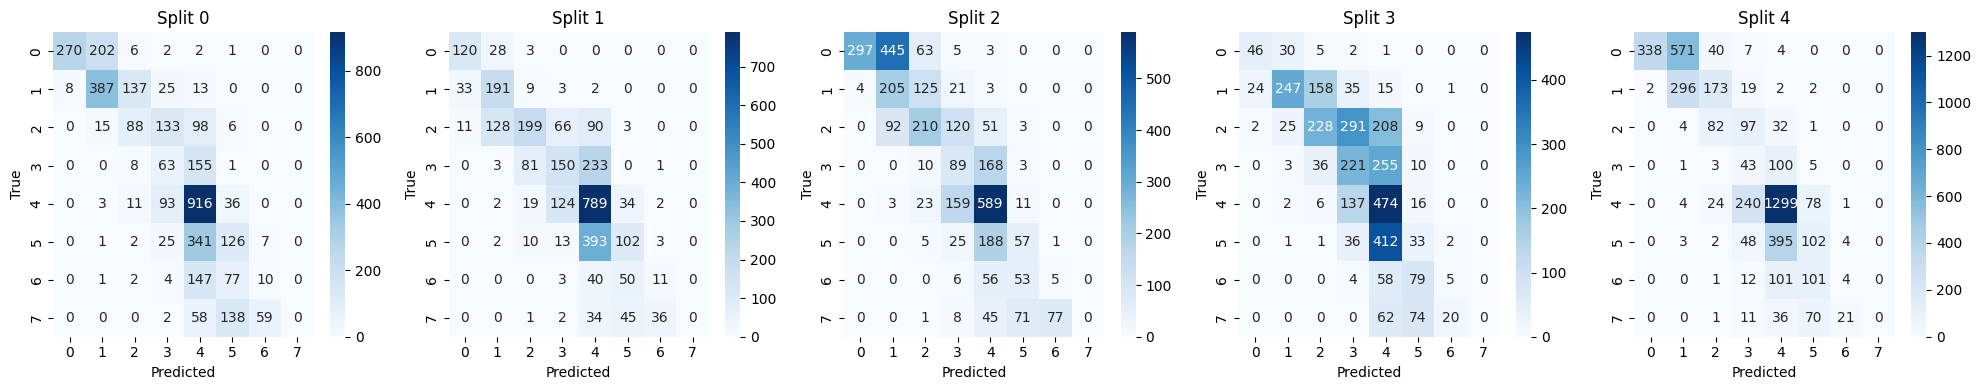



Experiment: Adience_256x256_resnet50_imagenet_noisy_dldl_v2_train_best
split0 accuracy/class-wise-accuracy	=	0.3868 / 0.0000, 0.4895, 0.4029, 0.3524, 0.7875, 0.1773, 0.0166, 0.0000
split1 accuracy/class-wise-accuracy	=	0.4734 / 0.6424, 0.8571, 0.4406, 0.4231, 0.6299, 0.2008, 0.1827, 0.0000
split2 accuracy/class-wise-accuracy	=	0.3667 / 0.0578, 0.6257, 0.4601, 0.3444, 0.7554, 0.1014, 0.0500, 0.0000
split3 accuracy/class-wise-accuracy	=	0.4020 / 0.2857, 0.7104, 0.2752, 0.2819, 0.7969, 0.1443, 0.1164, 0.0000
split4 accuracy/class-wise-accuracy	=	0.4292 / 0.0021, 0.7146, 0.4583, 0.3092, 0.7442, 0.2310, 0.1187, 0.0000

accuracy over splits: 0.4116  ± 0.0370

Classwise Mean Accuracy (Sorted):
Class 0: 0.1976 ± 0.2459
Class 1: 0.6795 ± 0.1206
Class 2: 0.4074 ± 0.0692
Class 3: 0.3422 ± 0.0477
Class 4: 0.7428 ± 0.0597
Class 5: 0.1710 ± 0.0449
Class 6: 0.0969 ± 0.0581
Class 7: 0.0000 ± 0.0000


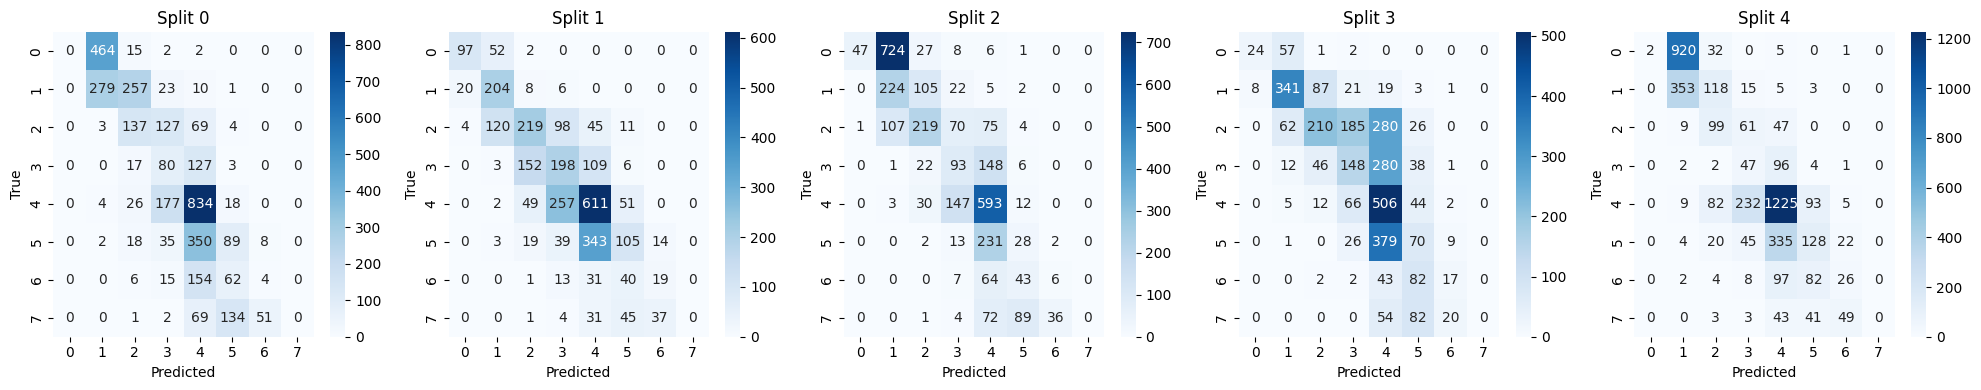



Experiment: Adience_256x256_resnet50_imagenet_noisy_dldl_v2_train_val_best
split0 accuracy/class-wise-accuracy	=	0.4069 / 0.0062, 0.5456, 0.2735, 0.2555, 0.8565, 0.2390, 0.0207, 0.0000
split1 accuracy/class-wise-accuracy	=	0.4793 / 0.1523, 0.9412, 0.4728, 0.4145, 0.6784, 0.2294, 0.1635, 0.0000
split2 accuracy/class-wise-accuracy	=	0.3748 / 0.1267, 0.8045, 0.4307, 0.4778, 0.5656, 0.2138, 0.0750, 0.0000
split3 accuracy/class-wise-accuracy	=	0.4038 / 0.1310, 0.6625, 0.3014, 0.2952, 0.8205, 0.1402, 0.1301, 0.0000
split4 accuracy/class-wise-accuracy	=	0.4612 / 0.1521, 0.6356, 0.3611, 0.1776, 0.7843, 0.2834, 0.0320, 0.0000

accuracy over splits: 0.4252  ± 0.0389

Classwise Mean Accuracy (Sorted):
Class 0: 0.1137 ± 0.0547
Class 1: 0.7179 ± 0.1392
Class 2: 0.3679 ± 0.0753
Class 3: 0.3241 ± 0.1084
Class 4: 0.7410 ± 0.1060
Class 5: 0.2212 ± 0.0466
Class 6: 0.0843 ± 0.0552
Class 7: 0.0000 ± 0.0000


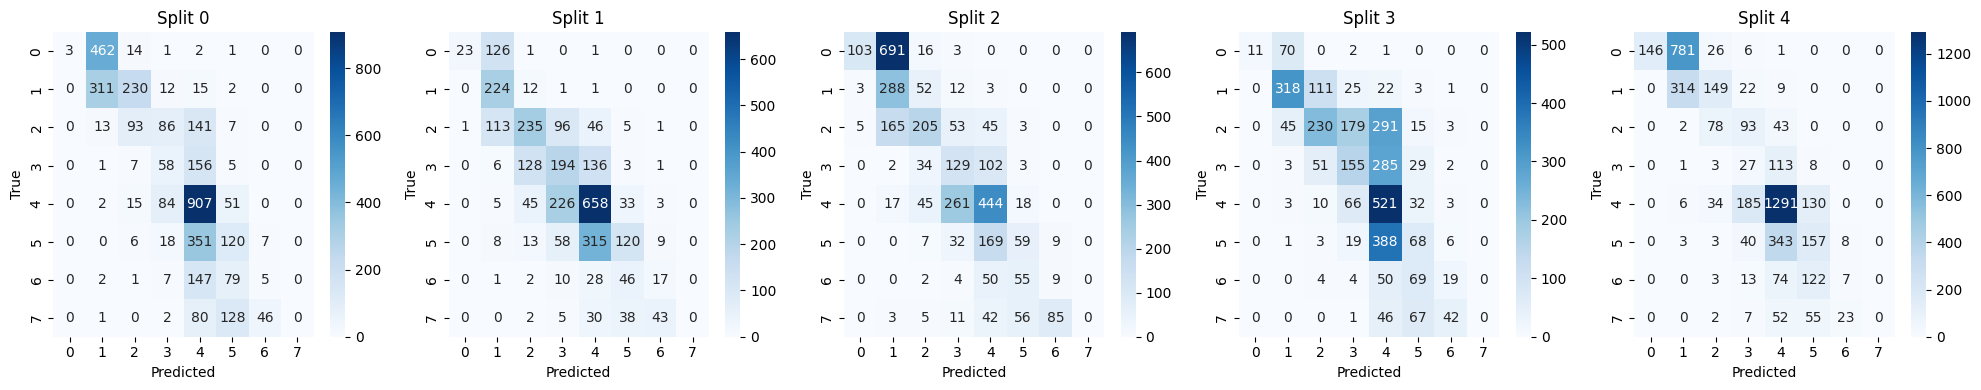



Experiment: Adience_256x256_resnet50_imagenet_noisy_dldl_v2_sync_2_best
split0 accuracy/class-wise-accuracy	=	0.4276 / 0.3043, 0.4772, 0.2265, 0.3700, 0.8612, 0.1494, 0.0249, 0.0000
split1 accuracy/class-wise-accuracy	=	0.5021 / 0.6093, 0.8319, 0.3501, 0.5449, 0.8072, 0.0669, 0.0385, 0.0000
split2 accuracy/class-wise-accuracy	=	0.3588 / 0.0443, 0.5950, 0.4538, 0.2741, 0.7873, 0.0978, 0.0000, 0.0000
split3 accuracy/class-wise-accuracy	=	0.3561 / 0.4048, 0.4896, 0.2136, 0.2324, 0.9134, 0.0660, 0.0000, 0.0000
split4 accuracy/class-wise-accuracy	=	0.5091 / 0.3625, 0.6721, 0.3889, 0.2237, 0.8269, 0.1264, 0.0046, 0.0000

accuracy over splits: 0.4307  ± 0.0663

Classwise Mean Accuracy (Sorted):
Class 0: 0.3450 ± 0.1821
Class 1: 0.6131 ± 0.1307
Class 2: 0.3266 ± 0.0932
Class 3: 0.3290 ± 0.1198
Class 4: 0.8392 ± 0.0444
Class 5: 0.1013 ± 0.0328
Class 6: 0.0136 ± 0.0155
Class 7: 0.0000 ± 0.0000


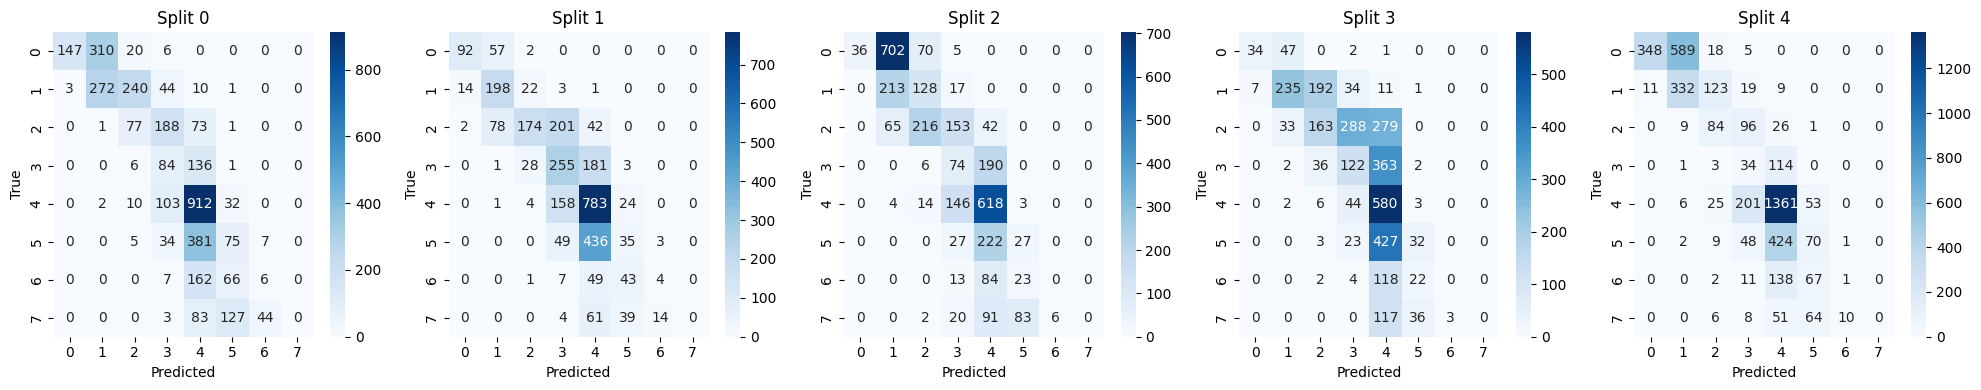



Experiment: Adience_256x256_resnet50_imagenet_noisy_dldl_v2_train_best_skip
split0 accuracy/class-wise-accuracy	=	0.5001 / 0.6335, 0.5912, 0.3176, 0.2996, 0.8074, 0.2530, 0.1245, 0.0350
split1 accuracy/class-wise-accuracy	=	0.4777 / 0.7748, 0.6471, 0.3823, 0.3739, 0.7010, 0.2199, 0.1731, 0.1441
split2 accuracy/class-wise-accuracy	=	0.4876 / 0.5006, 0.8073, 0.2374, 0.2704, 0.7274, 0.2572, 0.2583, 0.2673
split3 accuracy/class-wise-accuracy	=	0.4191 / 0.7262, 0.6458, 0.3670, 0.2590, 0.7937, 0.1320, 0.1164, 0.0000
split4 accuracy/class-wise-accuracy	=	0.4877 / 0.4219, 0.6235, 0.4120, 0.4803, 0.6160, 0.3357, 0.2192, 0.0935

accuracy over splits: 0.4744  ± 0.0286

Classwise Mean Accuracy (Sorted):
Class 0: 0.6114 ± 0.1331
Class 1: 0.6630 ± 0.0749
Class 2: 0.3433 ± 0.0611
Class 3: 0.3366 ± 0.0822
Class 4: 0.7291 ± 0.0691
Class 5: 0.2396 ± 0.0659
Class 6: 0.1783 ± 0.0545
Class 7: 0.1080 ± 0.0937


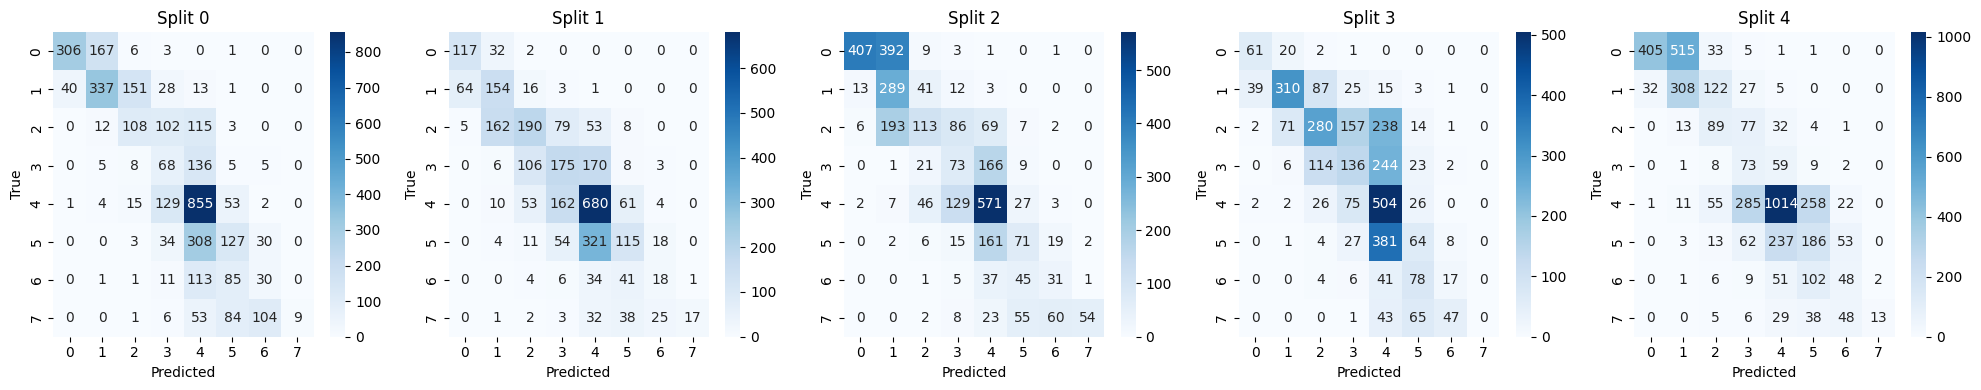



Experiment: Adience_256x256_resnet50_imagenet_noisy_dldl_v2_train_val_best_skip
split0 accuracy/class-wise-accuracy	=	0.4615 / 0.4493, 0.5246, 0.3324, 0.2423, 0.7564, 0.3247, 0.1535, 0.0506
split1 accuracy/class-wise-accuracy	=	0.4790 / 0.7550, 0.6261, 0.3541, 0.4145, 0.6660, 0.3174, 0.1731, 0.0593
split2 accuracy/class-wise-accuracy	=	0.4442 / 0.4428, 0.7514, 0.3424, 0.4630, 0.5873, 0.1920, 0.1833, 0.0644
split3 accuracy/class-wise-accuracy	=	0.3971 / 0.6905, 0.5625, 0.3617, 0.2800, 0.6173, 0.2660, 0.1438, 0.0449
split4 accuracy/class-wise-accuracy	=	0.5502 / 0.5948, 0.5891, 0.3472, 0.3553, 0.7351, 0.2942, 0.1872, 0.0360

accuracy over splits: 0.4664  ± 0.0500

Classwise Mean Accuracy (Sorted):
Class 0: 0.5865 ± 0.1255
Class 1: 0.6107 ± 0.0778
Class 2: 0.3476 ± 0.0100
Class 3: 0.3510 ± 0.0818
Class 4: 0.6724 ± 0.0653
Class 5: 0.2789 ± 0.0480
Class 6: 0.1682 ± 0.0169
Class 7: 0.0510 ± 0.0101


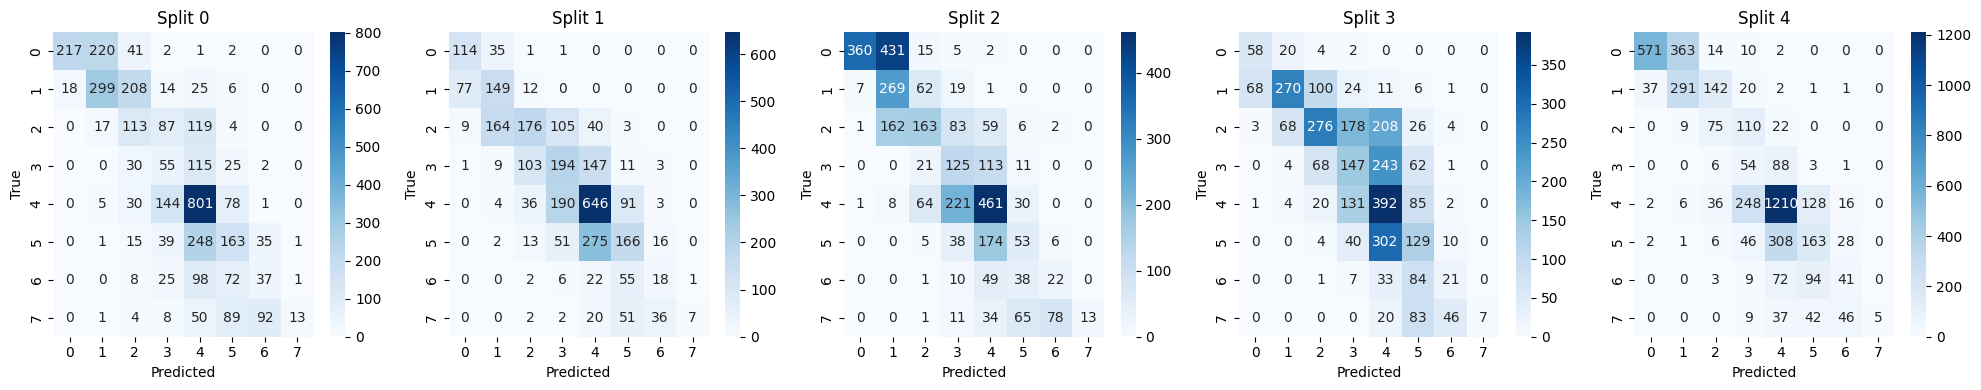



Experiment: Adience_256x256_resnet50_imagenet_noisy_dldl_v2_sync_1_best_skip
split0 accuracy/class-wise-accuracy	=	0.4939 / 0.5259, 0.7368, 0.2353, 0.4537, 0.8178, 0.1813, 0.0124, 0.0000
split1 accuracy/class-wise-accuracy	=	0.5142 / 0.7285, 0.7983, 0.3924, 0.4722, 0.7031, 0.3270, 0.0865, 0.0000
split2 accuracy/class-wise-accuracy	=	0.4812 / 0.4686, 0.6955, 0.4601, 0.4444, 0.6955, 0.2428, 0.0500, 0.0000
split3 accuracy/class-wise-accuracy	=	0.4230 / 0.6429, 0.6396, 0.2779, 0.4286, 0.8189, 0.1361, 0.0068, 0.0000
split4 accuracy/class-wise-accuracy	=	0.5436 / 0.4010, 0.7308, 0.4491, 0.4079, 0.7849, 0.3141, 0.0457, 0.0000

accuracy over splits: 0.4912  ± 0.0401

Classwise Mean Accuracy (Sorted):
Class 0: 0.5534 ± 0.1182
Class 1: 0.7202 ± 0.0522
Class 2: 0.3629 ± 0.0908
Class 3: 0.4414 ± 0.0219
Class 4: 0.7640 ± 0.0543
Class 5: 0.2402 ± 0.0739
Class 6: 0.0403 ± 0.0288
Class 7: 0.0000 ± 0.0000


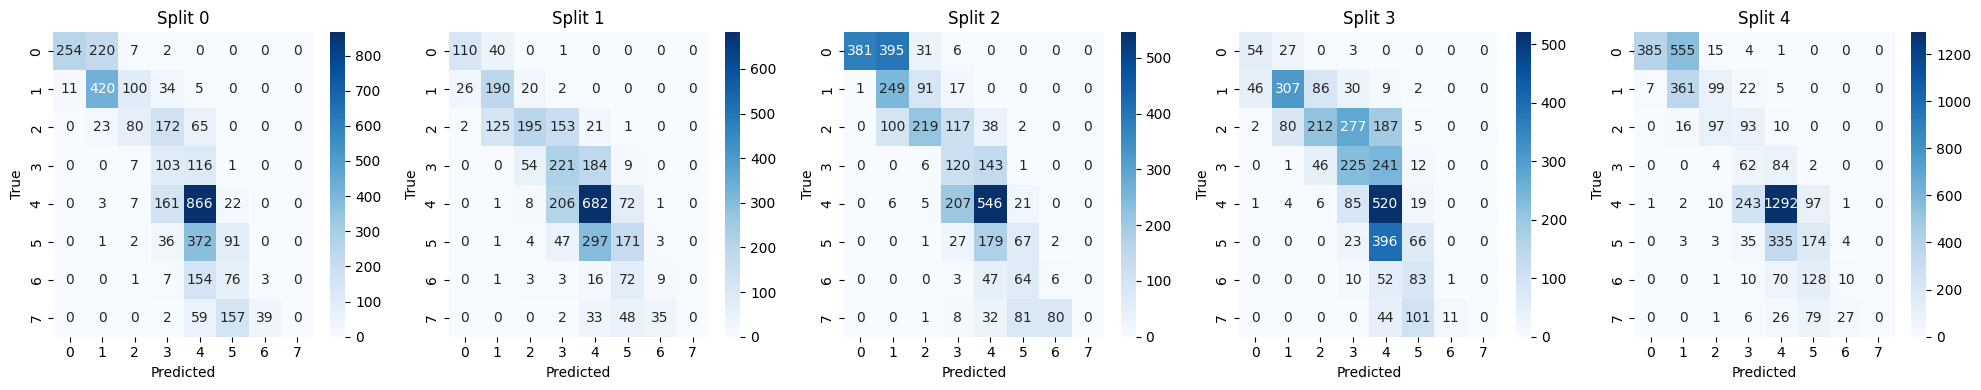



Experiment: Adience_256x256_resnet50_imagenet_noisy_dldl_v2_sync_2_best_skip
split0 accuracy/class-wise-accuracy	=	0.4822 / 0.3582, 0.7263, 0.2500, 0.2247, 0.9207, 0.1494, 0.0041, 0.0000
split1 accuracy/class-wise-accuracy	=	0.5028 / 0.7351, 0.8235, 0.3742, 0.3782, 0.8155, 0.1472, 0.0385, 0.0085
split2 accuracy/class-wise-accuracy	=	0.5024 / 0.5215, 0.6564, 0.4559, 0.4222, 0.8115, 0.0978, 0.0333, 0.0000
split3 accuracy/class-wise-accuracy	=	0.3910 / 0.6310, 0.6521, 0.2372, 0.2210, 0.8740, 0.1134, 0.0479, 0.0000
split4 accuracy/class-wise-accuracy	=	0.5703 / 0.5813, 0.6275, 0.3148, 0.0921, 0.8882, 0.1444, 0.0274, 0.0000

accuracy over splits: 0.4897  ± 0.0577

Classwise Mean Accuracy (Sorted):
Class 0: 0.5654 ± 0.1251
Class 1: 0.6972 ± 0.0712
Class 2: 0.3264 ± 0.0812
Class 3: 0.2676 ± 0.1191
Class 4: 0.8620 ± 0.0424
Class 5: 0.1305 ± 0.0209
Class 6: 0.0303 ± 0.0147
Class 7: 0.0017 ± 0.0034


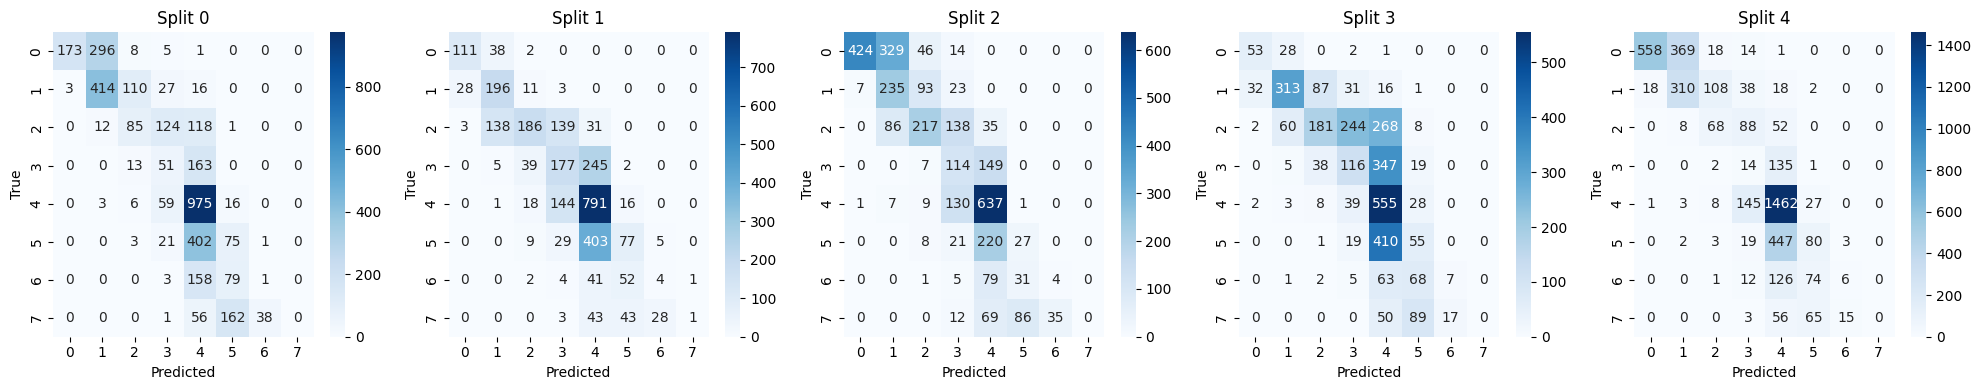



Experiment: Adience_256x256_resnet50_imagenet_noisy_dldl_v2_sync_1_best_skip_new
split0 accuracy/class-wise-accuracy	=	0.4882 / 0.5093, 0.6228, 0.2500, 0.4846, 0.8499, 0.1992, 0.0000, 0.0000
split1 accuracy/class-wise-accuracy	=	0.5142 / 0.8146, 0.8277, 0.2877, 0.4979, 0.8186, 0.1644, 0.0192, 0.0000
split2 accuracy/class-wise-accuracy	=	0.4830 / 0.4711, 0.6425, 0.4664, 0.4148, 0.7541, 0.1993, 0.0000, 0.0000
split3 accuracy/class-wise-accuracy	=	0.3913 / 0.4048, 0.5208, 0.2346, 0.4076, 0.7921, 0.2062, 0.0068, 0.0000
split4 accuracy/class-wise-accuracy	=	0.5849 / 0.6562, 0.6174, 0.3287, 0.3618, 0.8396, 0.2040, 0.0274, 0.0000

accuracy over splits: 0.4923  ± 0.0622

Classwise Mean Accuracy (Sorted):
Class 0: 0.5712 ± 0.1470
Class 1: 0.6462 ± 0.1001
Class 2: 0.3135 ± 0.0831
Class 3: 0.4333 ± 0.0508
Class 4: 0.8109 ± 0.0346
Class 5: 0.1946 ± 0.0153
Class 6: 0.0107 ± 0.0109
Class 7: 0.0000 ± 0.0000


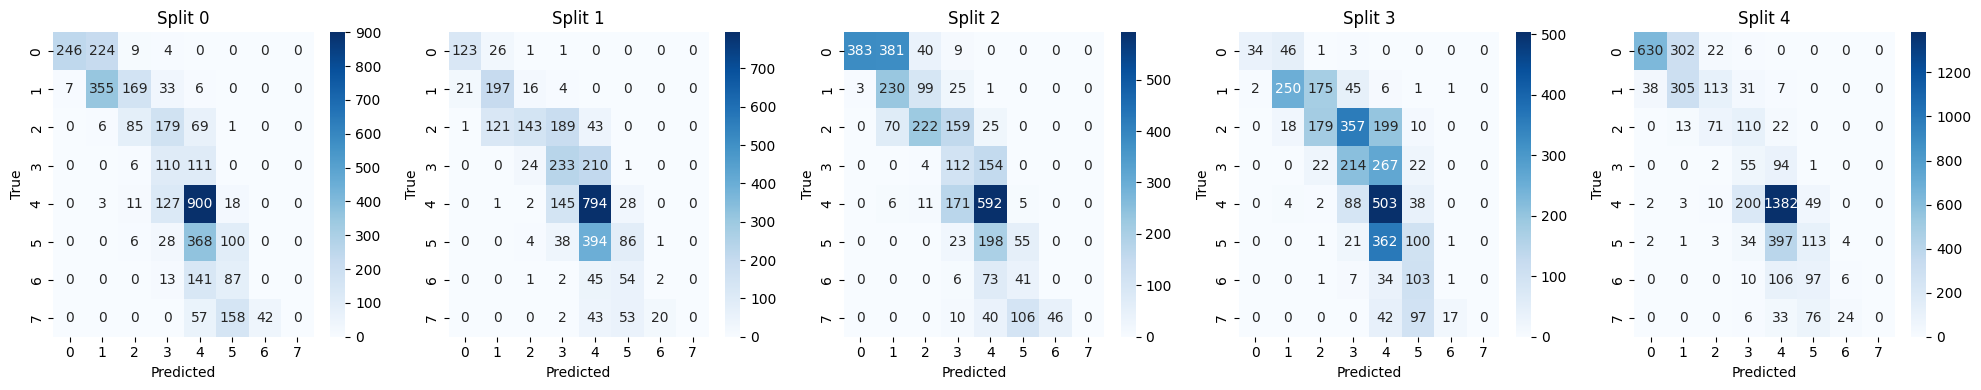



Experiment: Adience_256x256_resnet50_imagenet_noisy_dldl_v2_sync_carl
split0 accuracy/class-wise-accuracy	=	0.5096 / 0.6087, 0.6789, 0.3000, 0.3612, 0.7545, 0.3645, 0.0913, 0.0233
split1 accuracy/class-wise-accuracy	=	0.5331 / 0.7682, 0.7311, 0.4346, 0.5855, 0.7567, 0.2161, 0.0673, 0.0169
split2 accuracy/class-wise-accuracy	=	0.4939 / 0.4305, 0.6872, 0.4559, 0.3556, 0.7669, 0.3659, 0.1417, 0.0050
split3 accuracy/class-wise-accuracy	=	0.4243 / 0.4762, 0.6146, 0.2988, 0.4095, 0.7622, 0.1959, 0.1849, 0.0321
split4 accuracy/class-wise-accuracy	=	0.5630 / 0.5917, 0.7328, 0.4537, 0.3816, 0.7564, 0.2347, 0.0228, 0.0000

accuracy over splits: 0.5048  ± 0.0465

Classwise Mean Accuracy (Sorted):
Class 0: 0.5751 ± 0.1178
Class 1: 0.6889 ± 0.0432
Class 2: 0.3886 ± 0.0732
Class 3: 0.4187 ± 0.0855
Class 4: 0.7593 ± 0.0046
Class 5: 0.2754 ± 0.0744
Class 6: 0.1016 ± 0.0566
Class 7: 0.0155 ± 0.0117


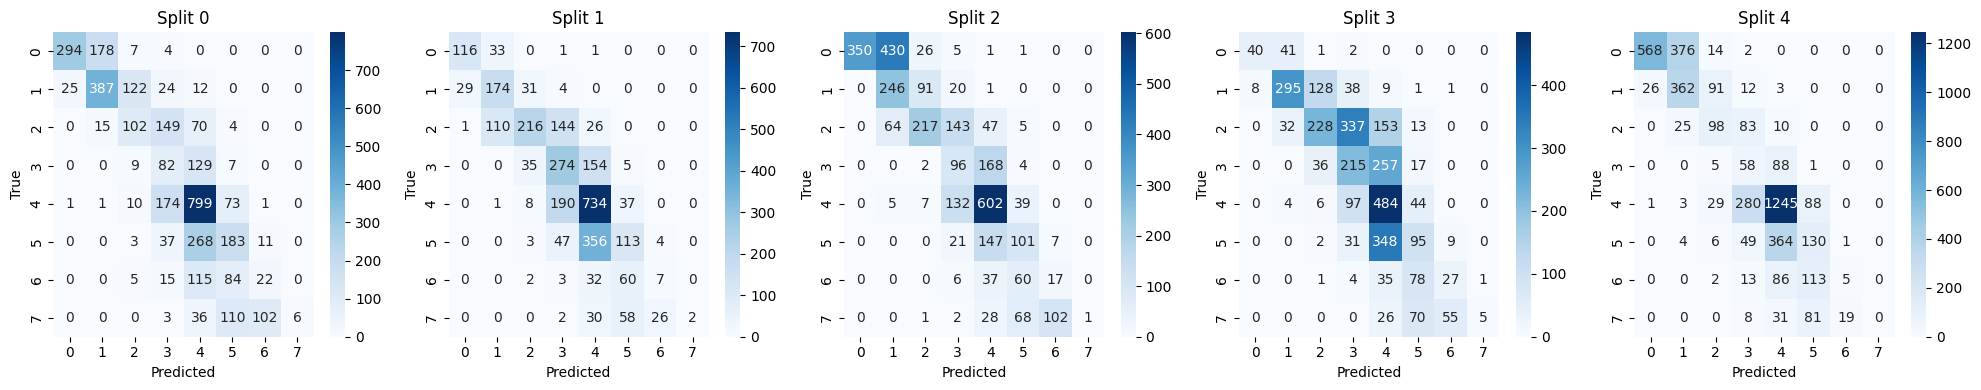



Experiment: Adience_256x256_resnet50_imagenet_noisy_dldl_v2_sync_carl_repeat
split0 accuracy/class-wise-accuracy	=	0.4640 / 0.4658, 0.6053, 0.2235, 0.3744, 0.8008, 0.2490, 0.0124, 0.0000
split1 accuracy/class-wise-accuracy	=	0.5233 / 0.8609, 0.7521, 0.3159, 0.5556, 0.7361, 0.3078, 0.0481, 0.0000
split2 accuracy/class-wise-accuracy	=	0.4248 / 0.2927, 0.6369, 0.4601, 0.4556, 0.6420, 0.2572, 0.0833, 0.0446
split3 accuracy/class-wise-accuracy	=	0.4270 / 0.3690, 0.5833, 0.3014, 0.5295, 0.7165, 0.2165, 0.0959, 0.0321
split4 accuracy/class-wise-accuracy	=	0.5543 / 0.6125, 0.6619, 0.3750, 0.4803, 0.7910, 0.1011, 0.0046, 0.0000

accuracy over splits: 0.4787  ± 0.0520

Classwise Mean Accuracy (Sorted):
Class 0: 0.5202 ± 0.2011
Class 1: 0.6479 ± 0.0586
Class 2: 0.3352 ± 0.0789
Class 3: 0.4791 ± 0.0631
Class 4: 0.7373 ± 0.0573
Class 5: 0.2263 ± 0.0691
Class 6: 0.0489 ± 0.0366
Class 7: 0.0153 ± 0.0192


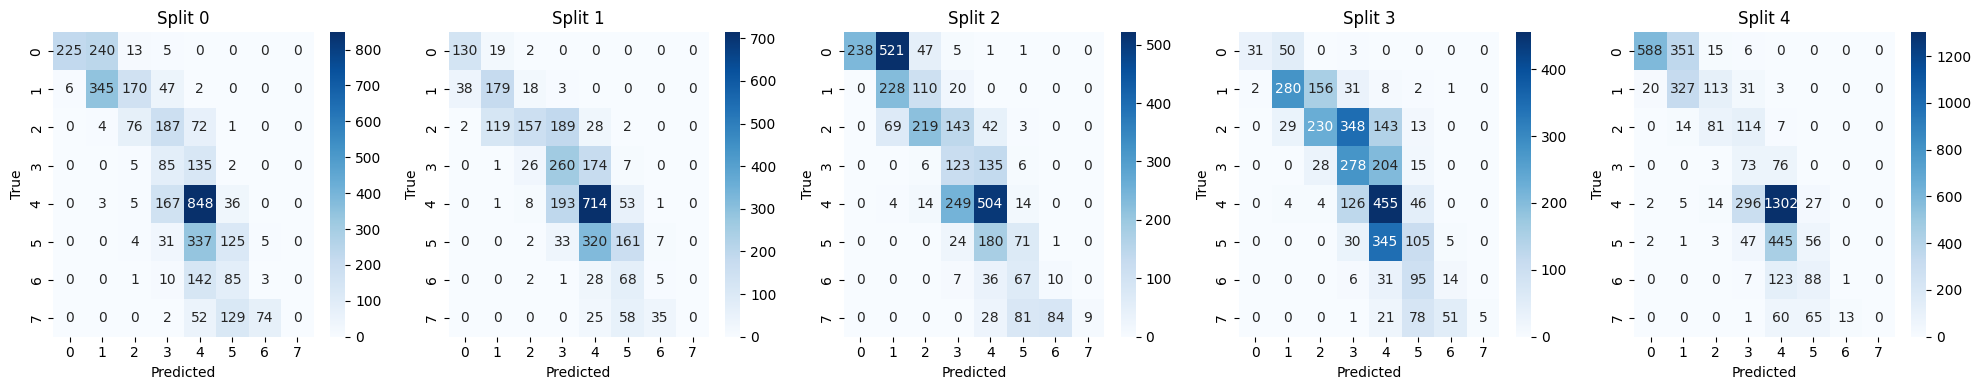



Experiment: Adience_256x256_resnet50_imagenet_noisy_dldl_v2_sync_qcarl
split0 accuracy/class-wise-accuracy	=	0.4865 / 0.6377, 0.6684, 0.3029, 0.3128, 0.6780, 0.3546, 0.1120, 0.0156
split1 accuracy/class-wise-accuracy	=	0.4702 / 0.7748, 0.8361, 0.2475, 0.3782, 0.6124, 0.3556, 0.3269, 0.1102
split2 accuracy/class-wise-accuracy	=	0.5003 / 0.5633, 0.7318, 0.3697, 0.3481, 0.6076, 0.3949, 0.3583, 0.1584
split3 accuracy/class-wise-accuracy	=	0.4194 / 0.6429, 0.6979, 0.2805, 0.3067, 0.5669, 0.3649, 0.4178, 0.0705
split4 accuracy/class-wise-accuracy	=	0.5352 / 0.6646, 0.6437, 0.3981, 0.2566, 0.5565, 0.4819, 0.3470, 0.0288

accuracy over splits: 0.4823  ± 0.0381

Classwise Mean Accuracy (Sorted):
Class 0: 0.6567 ± 0.0682
Class 1: 0.7156 ± 0.0671
Class 2: 0.3198 ± 0.0560
Class 3: 0.3205 ± 0.0411
Class 4: 0.6043 ± 0.0429
Class 5: 0.3904 ± 0.0480
Class 6: 0.3124 ± 0.1047
Class 7: 0.0767 ± 0.0527


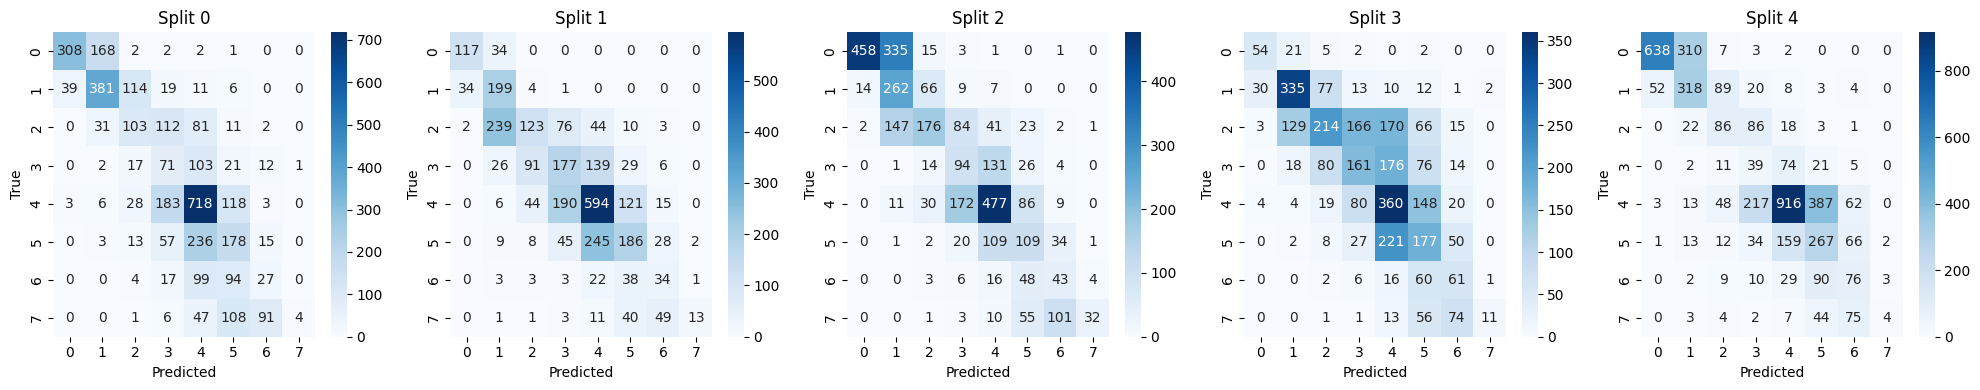



Experiment: Adience_256x256_resnet50_imagenet_noisy_dldl_v2_clean_carl
split0 accuracy/class-wise-accuracy	=	0.5936 / 0.9296, 0.6860, 0.2618, 0.1674, 0.9216, 0.3924, 0.0954, 0.0817
split1 accuracy/class-wise-accuracy	=	0.6210 / 0.9007, 0.7059, 0.5553, 0.5021, 0.8505, 0.4073, 0.3942, 0.1017
split2 accuracy/class-wise-accuracy	=	0.6548 / 0.7774, 0.7542, 0.5063, 0.2185, 0.9006, 0.4312, 0.3667, 0.4406
split3 accuracy/class-wise-accuracy	=	0.5611 / 0.8333, 0.7583, 0.4037, 0.5790, 0.8000, 0.4268, 0.4247, 0.0897
split4 accuracy/class-wise-accuracy	=	0.6954 / 0.9083, 0.6619, 0.5602, 0.1974, 0.8214, 0.4693, 0.2922, 0.1439

accuracy over splits: 0.6252  ± 0.0468

Classwise Mean Accuracy (Sorted):
Class 0: 0.8699 ± 0.0564
Class 1: 0.7133 ± 0.0378
Class 2: 0.4575 ± 0.1129
Class 3: 0.3329 ± 0.1721
Class 4: 0.8588 ± 0.0461
Class 5: 0.4254 ± 0.0260
Class 6: 0.3146 ± 0.1181
Class 7: 0.1715 ± 0.1362


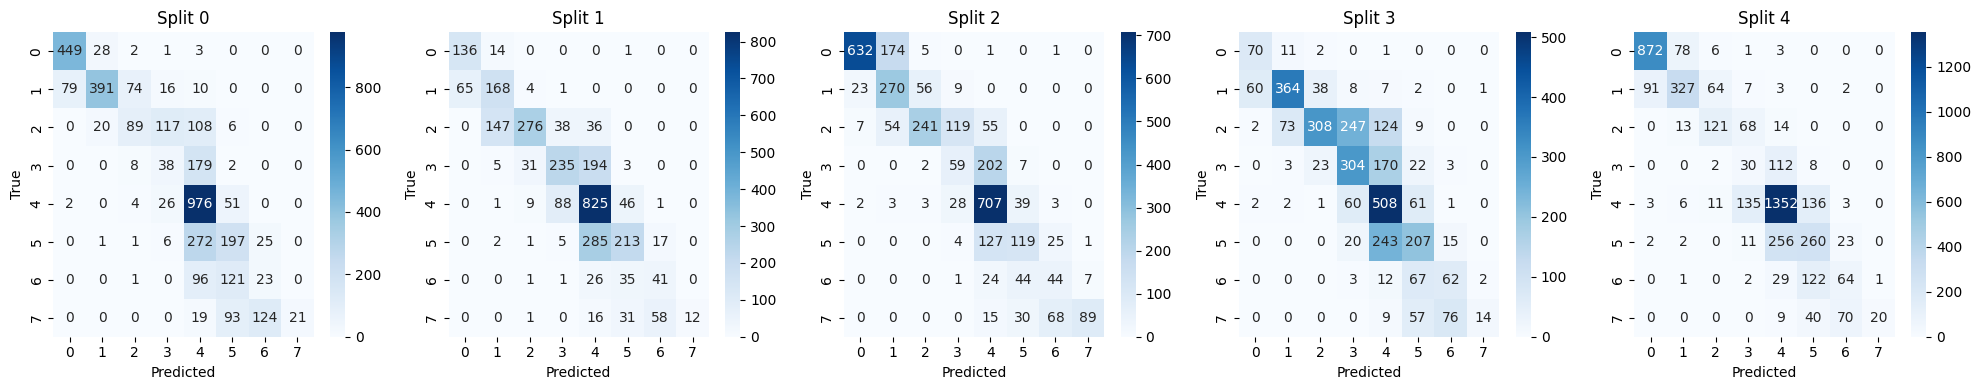



Experiment: Adience_256x256_resnet50_imagenet_noisy_dldl_v2_smcarl
split0 accuracy/class-wise-accuracy	=	0.4088 / 0.3644, 0.6667, 0.2853, 0.3612, 0.4136, 0.3546, 0.2697, 0.3424
split1 accuracy/class-wise-accuracy	=	0.4360 / 0.7417, 0.5546, 0.3078, 0.3782, 0.4948, 0.4073, 0.2981, 0.3390
split2 accuracy/class-wise-accuracy	=	0.4594 / 0.6064, 0.6006, 0.2962, 0.3519, 0.4522, 0.3225, 0.3000, 0.4554
split3 accuracy/class-wise-accuracy	=	0.3653 / 0.7976, 0.4708, 0.2765, 0.4095, 0.4283, 0.2000, 0.4521, 0.2692
split4 accuracy/class-wise-accuracy	=	0.4436 / 0.7812, 0.3947, 0.5324, 0.3816, 0.3360, 0.2798, 0.3836, 0.2374

accuracy over splits: 0.4226  ± 0.0330

Classwise Mean Accuracy (Sorted):
Class 0: 0.6583 ± 0.1616
Class 1: 0.5375 ± 0.0957
Class 2: 0.3397 ± 0.0969
Class 3: 0.3765 ± 0.0198
Class 4: 0.4250 ± 0.0523
Class 5: 0.3128 ± 0.0701
Class 6: 0.3407 ± 0.0675
Class 7: 0.3287 ± 0.0751


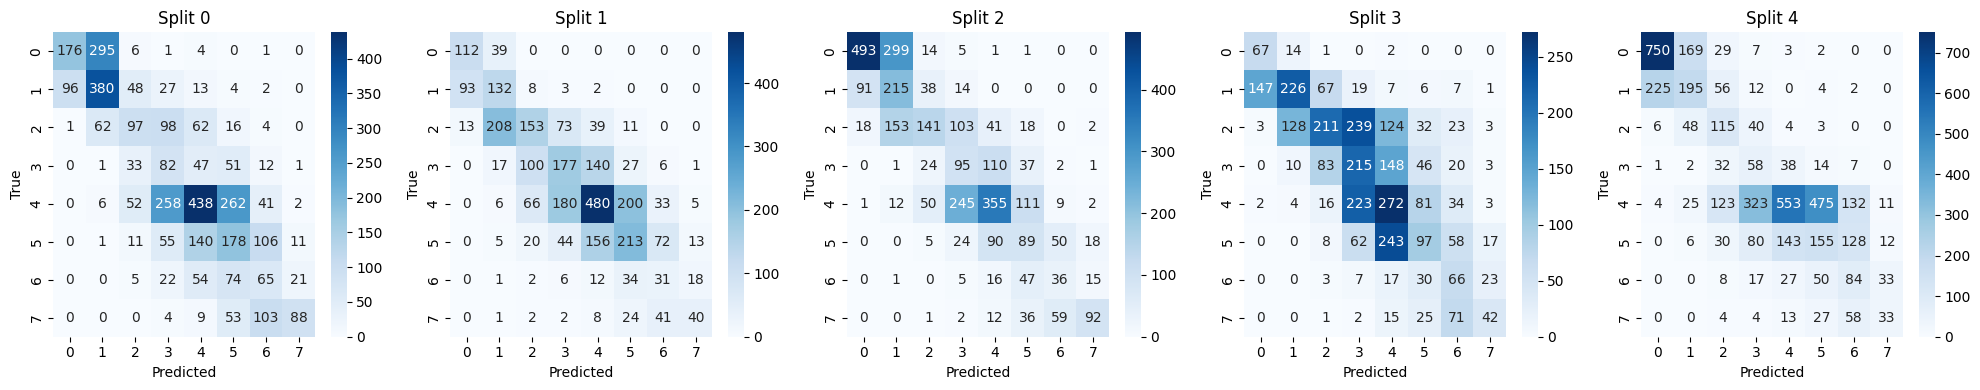

In [4]:
result_root = 'facebase/results'
experiments = [#'Adience_256x256_resnet50_imagenet_noisy_dldl_v2_train', #4060
               'Adience_256x256_resnet50_imagenet_noisy_dldl_v2_train_val',
            #    'Adience_256x256_resnet50_imagenet_noisy_dldl_v2_sync_1',    #4060
            #    'Adience_256x256_resnet50_imagenet_noisy_dldl_v2_sync_2',    #4060
               'Adience_256x256_resnet50_imagenet_noisy_dldl_v2_train_best',
               'Adience_256x256_resnet50_imagenet_noisy_dldl_v2_train_val_best',
            #    'Adience_256x256_resnet50_imagenet_noisy_dldl_v2_sync_1_best',   #4060
               'Adience_256x256_resnet50_imagenet_noisy_dldl_v2_sync_2_best',
            #    'Adience_256x256_resnet50_imagenet_noisy_dldl_v2_train_skip',    #4060
            #    'Adience_256x256_resnet50_imagenet_noisy_dldl_v2_train_val_skip',    #4060
            #    'Adience_256x256_resnet50_imagenet_noisy_dldl_v2_sync_1_skip',   #4060
            #    'Adience_256x256_resnet50_imagenet_noisy_dldl_v2_sync_2_skip',   #4060
               'Adience_256x256_resnet50_imagenet_noisy_dldl_v2_train_best_skip',
               'Adience_256x256_resnet50_imagenet_noisy_dldl_v2_train_val_best_skip',
               'Adience_256x256_resnet50_imagenet_noisy_dldl_v2_sync_1_best_skip',
               'Adience_256x256_resnet50_imagenet_noisy_dldl_v2_sync_2_best_skip',
               'Adience_256x256_resnet50_imagenet_noisy_dldl_v2_sync_1_best_skip_new',
               'Adience_256x256_resnet50_imagenet_noisy_dldl_v2_sync_carl',
               'Adience_256x256_resnet50_imagenet_noisy_dldl_v2_sync_carl_repeat',
               'Adience_256x256_resnet50_imagenet_noisy_dldl_v2_sync_qcarl',
               'Adience_256x256_resnet50_imagenet_noisy_dldl_v2_clean_carl',
               'Adience_256x256_resnet50_imagenet_noisy_dldl_v2_smcarl'
               ]

report_accuracy(result_root, experiments)

### 4060 Experiments

Experiment: Adience_256x256_resnet50_imagenet_dldl_v2_clean
split0 accuracy/class-wise-accuracy	=	0.5920 / 0.8054, 0.7667, 0.3559, 0.2203, 0.8470, 0.3127, 0.2822, 0.2296
split1 accuracy/class-wise-accuracy	=	0.5461 / 0.9205, 0.5126, 0.4708, 0.3803, 0.7289, 0.4857, 0.2019, 0.1780


split2 accuracy/class-wise-accuracy	=	0.5921 / 0.7122, 0.7737, 0.5042, 0.2778, 0.6828, 0.4565, 0.2667, 0.4406
split3 accuracy/class-wise-accuracy	=	0.5061 / 0.7619, 0.7063, 0.4089, 0.4190, 0.7071, 0.3938, 0.1644, 0.3718
split4 accuracy/class-wise-accuracy	=	0.6196 / 0.8552, 0.4838, 0.5556, 0.2566, 0.6756, 0.4801, 0.3333, 0.3165

accuracy over splits: 0.5712  ± 0.0402

Classwise Mean Accuracy (Sorted):
Class 0: 0.8110 ± 0.0723
Class 1: 0.6486 ± 0.1254
Class 2: 0.4591 ± 0.0702
Class 3: 0.3108 ± 0.0759
Class 4: 0.7283 ± 0.0623
Class 5: 0.4258 ± 0.0652
Class 6: 0.2497 ± 0.0598
Class 7: 0.3073 ± 0.0946


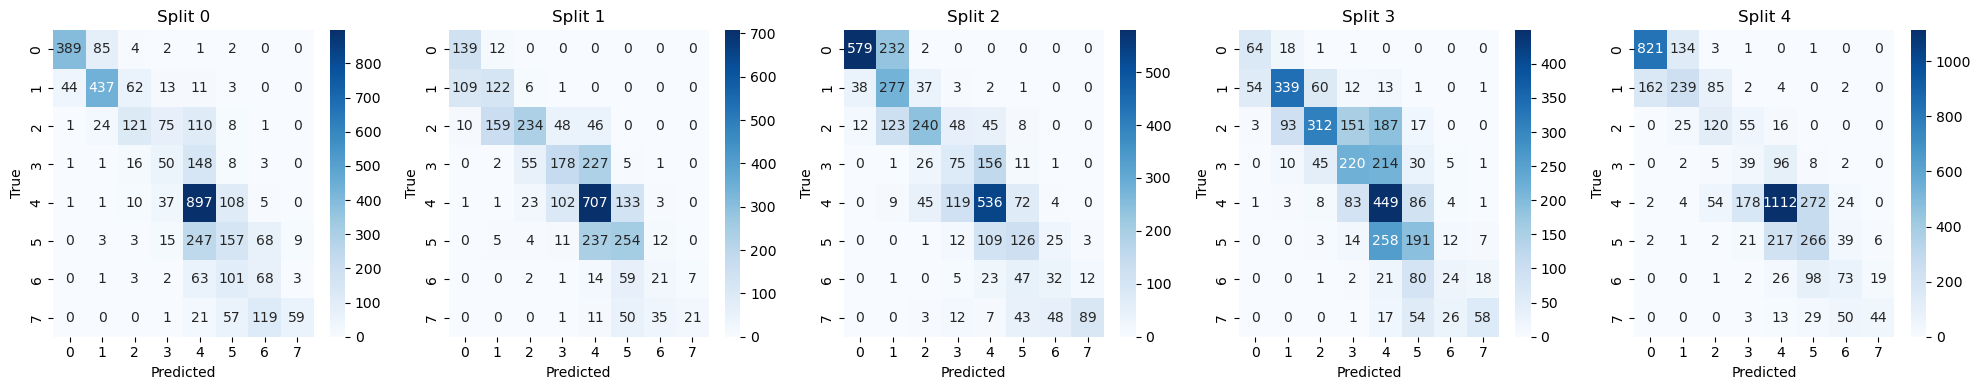



Experiment: Adience_256x256_resnet50_imagenet_dldl_v2_noisy
split0 accuracy/class-wise-accuracy	=	0.4776 / 0.5487, 0.5965, 0.2971, 0.2731, 0.7177, 0.3307, 0.1909, 0.0661
split1 accuracy/class-wise-accuracy	=	0.4298 / 0.8742, 0.5084, 0.2736, 0.4124, 0.6216, 0.2084, 0.1635, 0.0678
split2 accuracy/class-wise-accuracy	=	0.4670 / 0.5756, 0.6927, 0.2899, 0.3037, 0.6076, 0.2246, 0.2583, 0.1733
split3 accuracy/class-wise-accuracy	=	0.4188 / 0.4524, 0.7063, 0.3316, 0.2857, 0.6913, 0.2165, 0.2808, 0.0385
split4 accuracy/class-wise-accuracy	=	0.4785 / 0.5260, 0.5668, 0.5880, 0.4671, 0.5595, 0.2545, 0.1918, 0.0647

accuracy over splits: 0.4543  ± 0.0251

Classwise Mean Accuracy (Sorted):
Class 0: 0.5954 ± 0.1453
Class 1: 0.6141 ± 0.0754
Class 2: 0.3560 ± 0.1175
Class 3: 0.3484 ± 0.0772
Class 4: 0.6396 ± 0.0575
Class 5: 0.2469 ± 0.0447
Class 6: 0.2171 ± 0.0446
Class 7: 0.0821 ± 0.0469


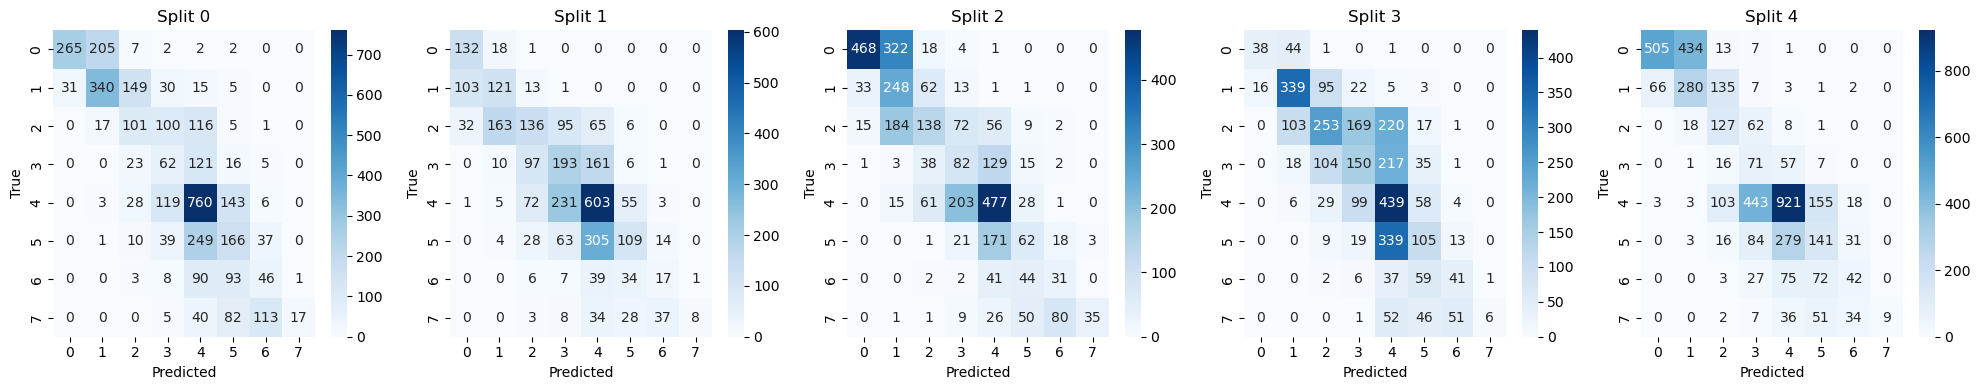



Experiment: Adience_256x256_resnet50_imagenet_noisy_dldl_v2_train
split0 accuracy/class-wise-accuracy	=	0.5126 / 0.5921, 0.6754, 0.3765, 0.2247, 0.8716, 0.2211, 0.0083, 0.0000
split1 accuracy/class-wise-accuracy	=	0.4875 / 0.8146, 0.6891, 0.2736, 0.4444, 0.7742, 0.1816, 0.1731, 0.0085
split2 accuracy/class-wise-accuracy	=	0.4727 / 0.4895, 0.6788, 0.3739, 0.2852, 0.7427, 0.2572, 0.0833, 0.0000
split3 accuracy/class-wise-accuracy	=	0.4032 / 0.3929, 0.6625, 0.2844, 0.3048, 0.8362, 0.1072, 0.0616, 0.0000
split4 accuracy/class-wise-accuracy	=	0.5155 / 0.4302, 0.6134, 0.4398, 0.3618, 0.7479, 0.2798, 0.0274, 0.0000

accuracy over splits: 0.4783  ± 0.0408

Classwise Mean Accuracy (Sorted):
Class 0: 0.5439 ± 0.1512
Class 1: 0.6638 ± 0.0266
Class 2: 0.3497 ± 0.0624
Class 3: 0.3242 ± 0.0744
Class 4: 0.7945 ± 0.0509
Class 5: 0.2094 ± 0.0610
Class 6: 0.0708 ± 0.0574
Class 7: 0.0017 ± 0.0034


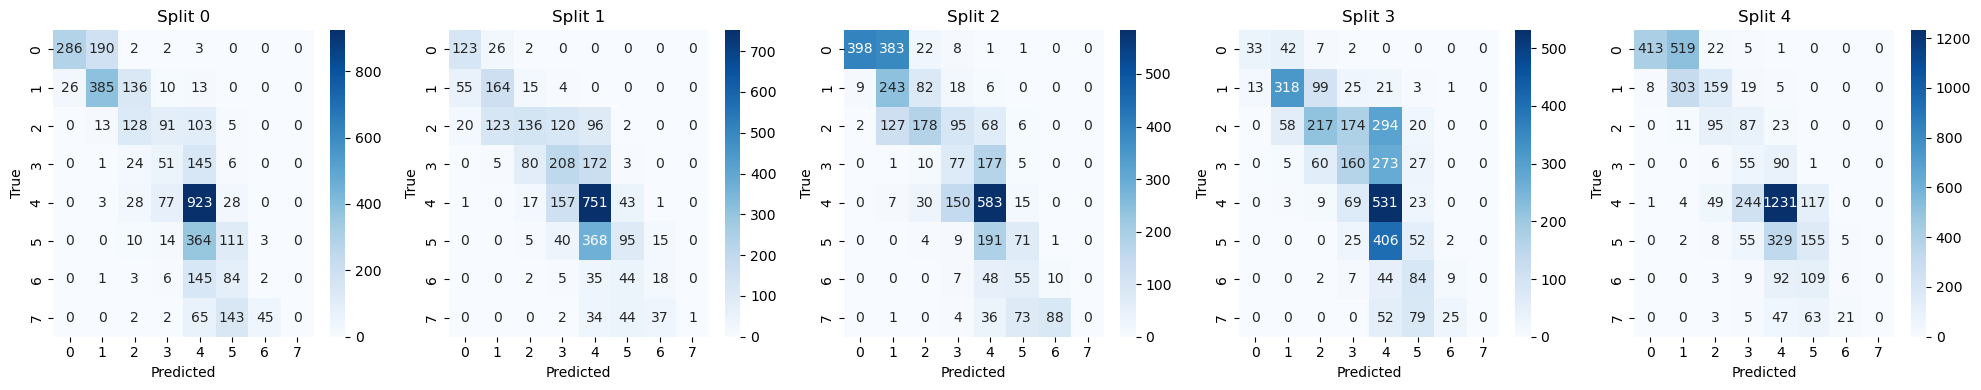



Experiment: Adience_256x256_resnet50_imagenet_noisy_dldl_v2_sync_1
split0 accuracy/class-wise-accuracy	=	0.5012 / 0.4990, 0.6316, 0.2029, 0.4141, 0.8810, 0.2789, 0.0290, 0.0000
split1 accuracy/class-wise-accuracy	=	0.5083 / 0.7483, 0.8025, 0.4024, 0.5385, 0.7144, 0.1950, 0.0865, 0.0000
split2 accuracy/class-wise-accuracy	=	0.4500 / 0.4231, 0.5531, 0.4370, 0.4407, 0.6904, 0.2572, 0.0250, 0.0000
split3 accuracy/class-wise-accuracy	=	0.3809 / 0.3690, 0.5021, 0.2005, 0.3695, 0.7606, 0.2825, 0.0548, 0.0000
split4 accuracy/class-wise-accuracy	=	0.5532 / 0.5229, 0.7348, 0.3565, 0.3421, 0.7710, 0.2545, 0.0868, 0.0000

accuracy over splits: 0.4787  ± 0.0589

Classwise Mean Accuracy (Sorted):
Class 0: 0.5125 ± 0.1300
Class 1: 0.6448 ± 0.1113
Class 2: 0.3199 ± 0.0998
Class 3: 0.4210 ± 0.0680
Class 4: 0.7635 ± 0.0658
Class 5: 0.2536 ± 0.0314
Class 6: 0.0564 ± 0.0267
Class 7: 0.0000 ± 0.0000


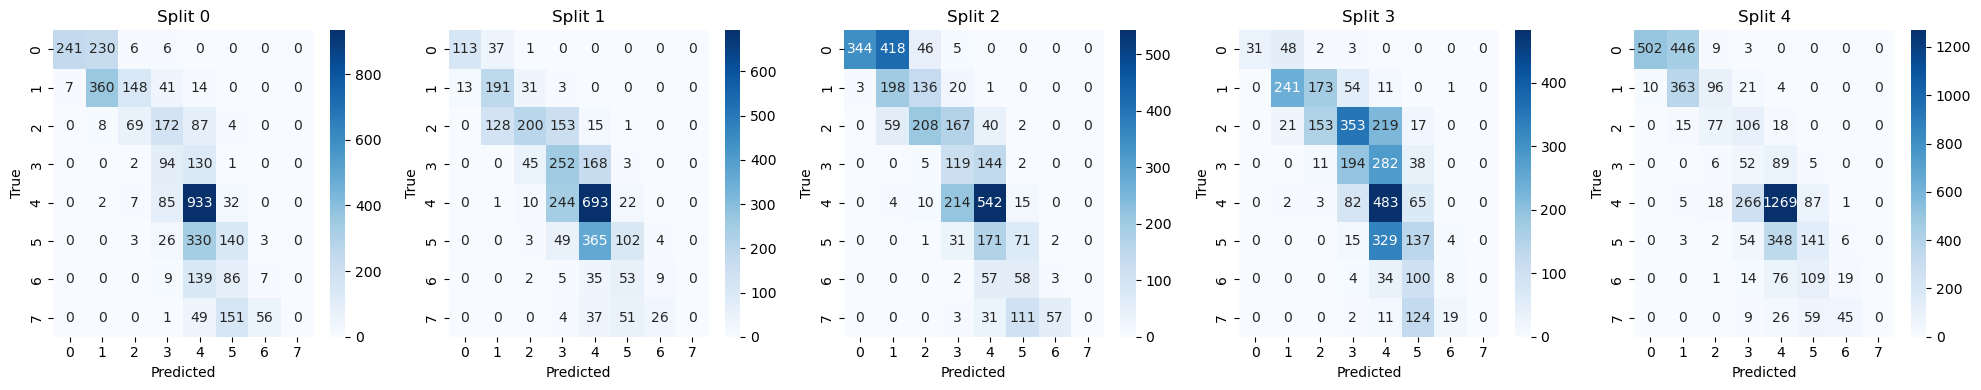



Experiment: Adience_256x256_resnet50_imagenet_noisy_dldl_v2_sync_2
split0 accuracy/class-wise-accuracy	=	0.4537 / 0.2754, 0.5579, 0.1588, 0.2070, 0.8999, 0.2769, 0.1037, 0.0000
split1 accuracy/class-wise-accuracy	=	0.4891 / 0.7550, 0.7941, 0.4125, 0.6132, 0.6876, 0.0746, 0.0000, 0.0000
split2 accuracy/class-wise-accuracy	=	0.4636 / 0.4157, 0.6536, 0.3803, 0.1333, 0.8726, 0.1993, 0.0083, 0.0000
split3 accuracy/class-wise-accuracy	=	0.3250 / 0.3690, 0.4521, 0.1101, 0.1448, 0.9197, 0.1402, 0.0274, 0.0000
split4 accuracy/class-wise-accuracy	=	0.5822 / 0.6906, 0.7186, 0.4444, 0.3224, 0.8111, 0.0866, 0.0183, 0.0000

accuracy over splits: 0.4627  ± 0.0825

Classwise Mean Accuracy (Sorted):
Class 0: 0.5011 ± 0.1876
Class 1: 0.6353 ± 0.1201
Class 2: 0.3012 ± 0.1385
Class 3: 0.2842 ± 0.1777
Class 4: 0.8382 ± 0.0837
Class 5: 0.1555 ± 0.0751
Class 6: 0.0315 ± 0.0373
Class 7: 0.0000 ± 0.0000


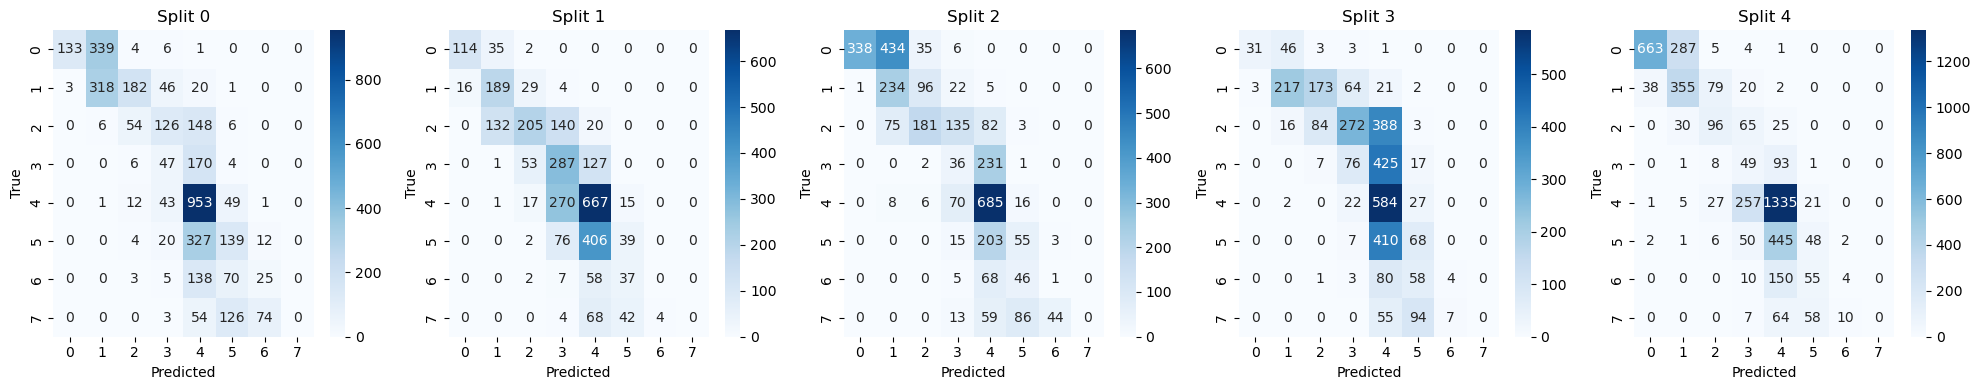



Experiment: Adience_256x256_resnet50_imagenet_noisy_dldl_v2_sync_1_best
split0 accuracy/class-wise-accuracy	=	0.4409 / 0.4658, 0.5965, 0.2059, 0.4053, 0.7705, 0.1574, 0.0000, 0.0000
split1 accuracy/class-wise-accuracy	=	0.5011 / 0.6424, 0.8697, 0.3561, 0.6603, 0.7227, 0.0899, 0.0000, 0.0000
split2 accuracy/class-wise-accuracy	=	0.3379 / 0.0898, 0.5251, 0.5063, 0.6593, 0.5172, 0.1051, 0.0000, 0.0000
split3 accuracy/class-wise-accuracy	=	0.3577 / 0.2262, 0.4167, 0.2058, 0.4571, 0.7701, 0.1361, 0.0000, 0.0000
split4 accuracy/class-wise-accuracy	=	0.4614 / 0.1896, 0.6822, 0.3704, 0.5263, 0.7363, 0.2274, 0.0183, 0.0000

accuracy over splits: 0.4198  ± 0.0622

Classwise Mean Accuracy (Sorted):
Class 0: 0.3228 ± 0.2020
Class 1: 0.6180 ± 0.1530
Class 2: 0.3289 ± 0.1133
Class 3: 0.5417 ± 0.1038
Class 4: 0.7034 ± 0.0950
Class 5: 0.1432 ± 0.0483
Class 6: 0.0037 ± 0.0073
Class 7: 0.0000 ± 0.0000


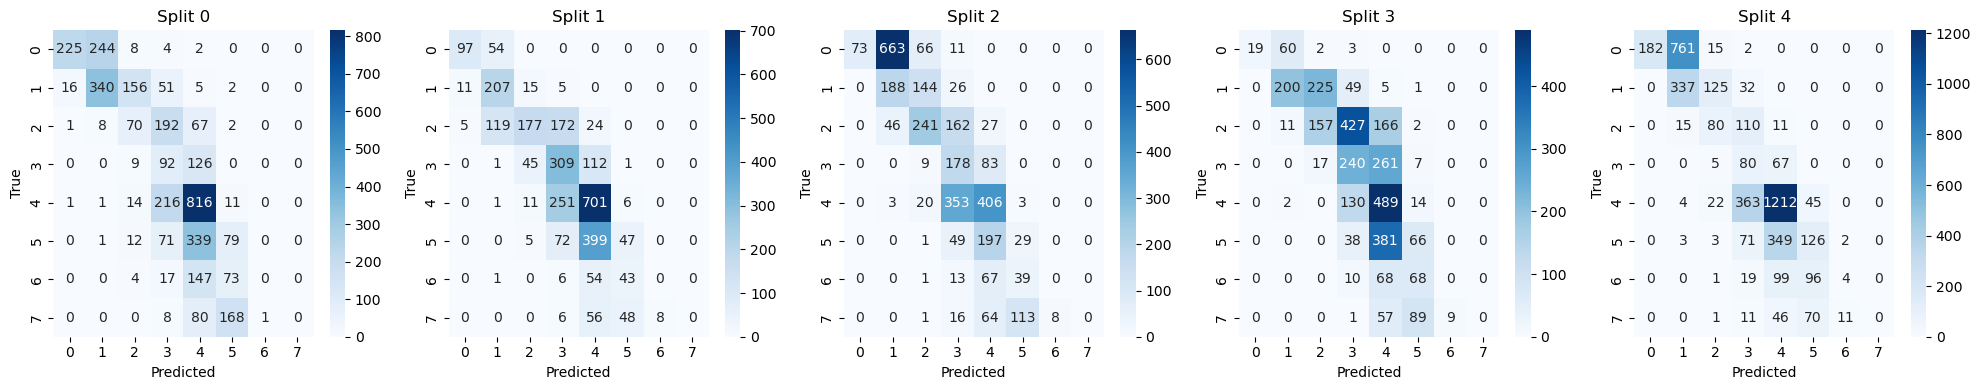



Experiment: Adience_256x256_resnet50_imagenet_noisy_dldl_v2_train_skip
split0 accuracy/class-wise-accuracy	=	0.5200 / 0.7205, 0.6772, 0.2941, 0.2863, 0.7668, 0.3267, 0.1079, 0.0467
split1 accuracy/class-wise-accuracy	=	0.4402 / 0.8742, 0.4454, 0.3441, 0.3889, 0.5784, 0.3021, 0.2692, 0.1102
split2 accuracy/class-wise-accuracy	=	0.5045 / 0.6544, 0.7011, 0.2479, 0.2963, 0.6713, 0.3261, 0.2917, 0.1584
split3 accuracy/class-wise-accuracy	=	0.3891 / 0.3333, 0.6167, 0.3067, 0.2800, 0.6835, 0.2041, 0.2260, 0.0192
split4 accuracy/class-wise-accuracy	=	0.4874 / 0.5062, 0.5789, 0.5463, 0.5461, 0.5510, 0.3159, 0.2922, 0.1151

accuracy over splits: 0.4683  ± 0.0478

Classwise Mean Accuracy (Sorted):
Class 0: 0.6177 ± 0.1849
Class 1: 0.6039 ± 0.0903
Class 2: 0.3478 ± 0.1039
Class 3: 0.3595 ± 0.1013
Class 4: 0.6502 ± 0.0776
Class 5: 0.2950 ± 0.0463
Class 6: 0.2374 ± 0.0691
Class 7: 0.0899 ± 0.0502


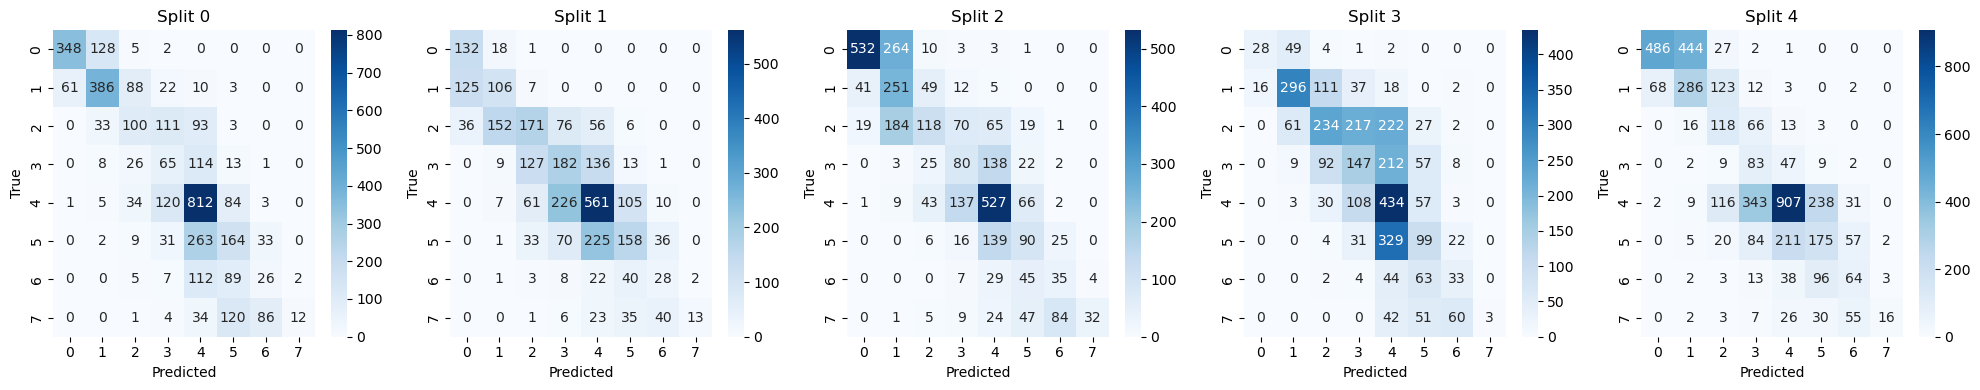



Experiment: Adience_256x256_resnet50_imagenet_noisy_dldl_v2_train_val_skip
split0 accuracy/class-wise-accuracy	=	0.5243 / 0.7536, 0.5895, 0.2941, 0.2643, 0.8026, 0.3008, 0.1950, 0.0817
split1 accuracy/class-wise-accuracy	=	0.4516 / 0.8742, 0.4958, 0.2334, 0.2885, 0.6495, 0.3862, 0.3173, 0.1695
split2 accuracy/class-wise-accuracy	=	0.4806 / 0.6039, 0.7039, 0.2500, 0.3185, 0.6408, 0.2790, 0.2750, 0.1238
split3 accuracy/class-wise-accuracy	=	0.3745 / 0.2738, 0.5938, 0.2280, 0.2876, 0.7638, 0.1835, 0.1096, 0.0192
split4 accuracy/class-wise-accuracy	=	0.5062 / 0.6240, 0.4615, 0.4398, 0.3750, 0.5851, 0.3484, 0.2877, 0.1367

accuracy over splits: 0.4674  ± 0.0525

Classwise Mean Accuracy (Sorted):
Class 0: 0.6259 ± 0.2012
Class 1: 0.5689 ± 0.0850
Class 2: 0.2891 ± 0.0789
Class 3: 0.3068 ± 0.0382
Class 4: 0.6883 ± 0.0815
Class 5: 0.2996 ± 0.0690
Class 6: 0.2369 ± 0.0754
Class 7: 0.1062 ± 0.0518


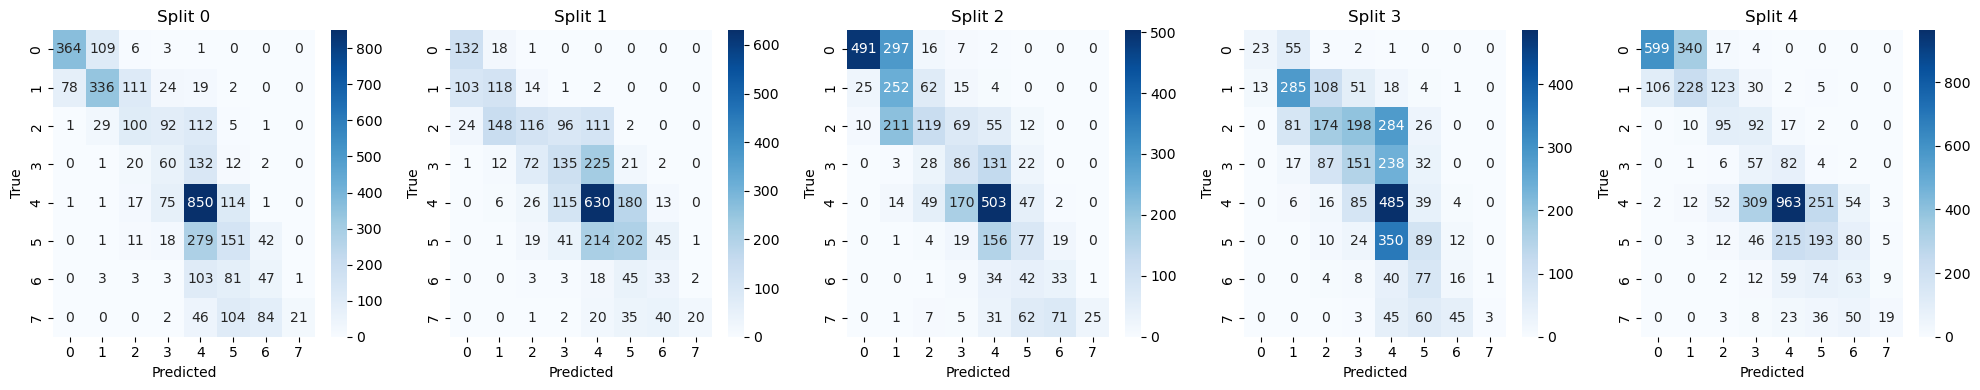



Experiment: Adience_256x256_resnet50_imagenet_noisy_dldl_v2_sync_1_skip
split0 accuracy/class-wise-accuracy	=	0.4781 / 0.3996, 0.5860, 0.1941, 0.3656, 0.8621, 0.3147, 0.0498, 0.0000
split1 accuracy/class-wise-accuracy	=	0.5086 / 0.6026, 0.7395, 0.4205, 0.5299, 0.6907, 0.2906, 0.1154, 0.0254
split2 accuracy/class-wise-accuracy	=	0.4461 / 0.4059, 0.4525, 0.4832, 0.4593, 0.6382, 0.3732, 0.1167, 0.0396
split3 accuracy/class-wise-accuracy	=	0.3940 / 0.3095, 0.5146, 0.1913, 0.4000, 0.8142, 0.2557, 0.1164, 0.0192
split4 accuracy/class-wise-accuracy	=	0.5048 / 0.3490, 0.5688, 0.3380, 0.4671, 0.7922, 0.2527, 0.0320, 0.0000

accuracy over splits: 0.4663  ± 0.0425

Classwise Mean Accuracy (Sorted):
Class 0: 0.4133 ± 0.1010
Class 1: 0.5723 ± 0.0957
Class 2: 0.3254 ± 0.1177
Class 3: 0.4444 ± 0.0570
Class 4: 0.7595 ± 0.0825
Class 5: 0.2974 ± 0.0443
Class 6: 0.0860 ± 0.0373
Class 7: 0.0169 ± 0.0153


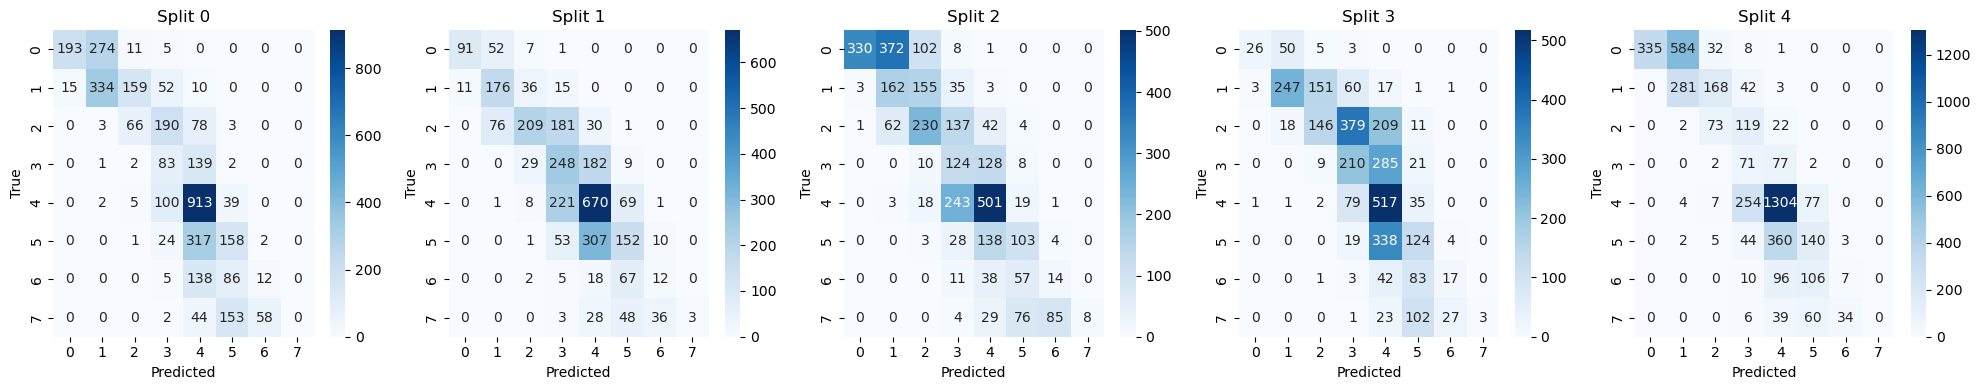



Experiment: Adience_256x256_resnet50_imagenet_noisy_dldl_v2_sync_2_skip
split0 accuracy/class-wise-accuracy	=	0.4251 / 0.1739, 0.5649, 0.1912, 0.2291, 0.9245, 0.1235, 0.0000, 0.0000
split1 accuracy/class-wise-accuracy	=	0.4930 / 0.8212, 0.7731, 0.2857, 0.4594, 0.8392, 0.0631, 0.0096, 0.0000
split2 accuracy/class-wise-accuracy	=	0.4491 / 0.4403, 0.5754, 0.3929, 0.3148, 0.6879, 0.3587, 0.0583, 0.0000
split3 accuracy/class-wise-accuracy	=	0.3543 / 0.1786, 0.4625, 0.2241, 0.3295, 0.8457, 0.0845, 0.0068, 0.0000
split4 accuracy/class-wise-accuracy	=	0.5491 / 0.4927, 0.6316, 0.3981, 0.4803, 0.8402, 0.1372, 0.0091, 0.0000

accuracy over splits: 0.4541  ± 0.0654

Classwise Mean Accuracy (Sorted):
Class 0: 0.4213 ± 0.2390
Class 1: 0.6015 ± 0.1017
Class 2: 0.2984 ± 0.0849
Class 3: 0.3626 ± 0.0943
Class 4: 0.8275 ± 0.0768
Class 5: 0.1534 ± 0.1060
Class 6: 0.0168 ± 0.0211
Class 7: 0.0000 ± 0.0000


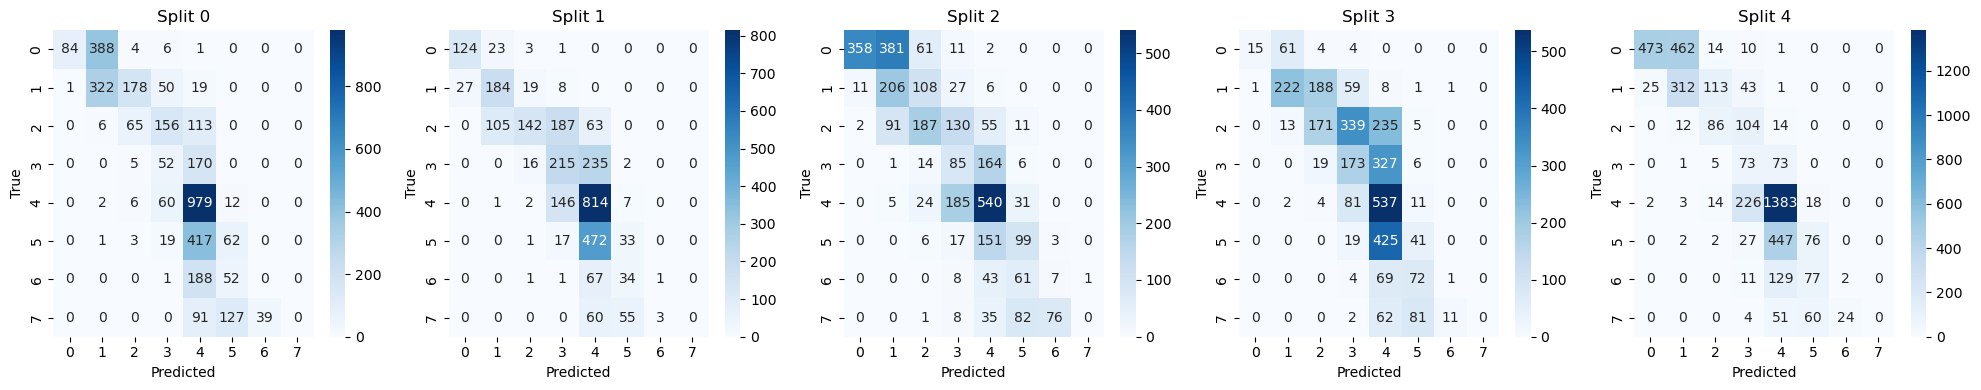

In [5]:
result_root = 'facebase/results'
experiments = [
               'Adience_256x256_resnet50_imagenet_dldl_v2_clean', #4060
               'Adience_256x256_resnet50_imagenet_dldl_v2_noisy', #4060
               'Adience_256x256_resnet50_imagenet_noisy_dldl_v2_train', #4060
            #    'Adience_256x256_resnet50_imagenet_noisy_dldl_v2_train_val',
               'Adience_256x256_resnet50_imagenet_noisy_dldl_v2_sync_1',    #4060
               'Adience_256x256_resnet50_imagenet_noisy_dldl_v2_sync_2',    #4060
            #    'Adience_256x256_resnet50_imagenet_noisy_dldl_v2_train_best',
            #    'Adience_256x256_resnet50_imagenet_noisy_dldl_v2_train_val_best',
               'Adience_256x256_resnet50_imagenet_noisy_dldl_v2_sync_1_best',   #4060
            #    'Adience_256x256_resnet50_imagenet_noisy_dldl_v2_sync_2_best',
               'Adience_256x256_resnet50_imagenet_noisy_dldl_v2_train_skip',    #4060
               'Adience_256x256_resnet50_imagenet_noisy_dldl_v2_train_val_skip',    #4060
               'Adience_256x256_resnet50_imagenet_noisy_dldl_v2_sync_1_skip',   #4060
               'Adience_256x256_resnet50_imagenet_noisy_dldl_v2_sync_2_skip',   #4060
            #    'Adience_256x256_resnet50_imagenet_noisy_dldl_v2_train_best_skip',
            #    'Adience_256x256_resnet50_imagenet_noisy_dldl_v2_train_val_best_skip',
            #    'Adience_256x256_resnet50_imagenet_noisy_dldl_v2_sync_1_best_skip',
            #    'Adience_256x256_resnet50_imagenet_noisy_dldl_v2_sync_2_best_skip',
            #    'Adience_256x256_resnet50_imagenet_noisy_dldl_v2_sync_1_best_skip_new',
            #    'Adience_256x256_resnet50_imagenet_noisy_dldl_v2_sync_carl',
            #    'Adience_256x256_resnet50_imagenet_noisy_dldl_v2_sync_carl_repeat',
            #    'Adience_256x256_resnet50_imagenet_noisy_dldl_v2_sync_qcarl',
            #    'Adience_256x256_resnet50_imagenet_noisy_dldl_v2_clean_carl'
               ]

report_accuracy(result_root, experiments)